<a href="https://colab.research.google.com/github/kingjimmykobe/-Cross-Linguistic-Analysis-of-Financial-News-Coverage/blob/main/101_group_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

##Group Project for DIGHUM 101
Project idea: https://openhumanitiesdata.metajnl.com/articles/10.5334/johd.62#3-the-dataset

dataset link: https://zenodo.org/records/5591908

In [ ]:
# Read CSV without headers and assign column names manually
column_names = ['id', 'time', 'english_title', 'chinese_title', 'integer', 'english_body', 'chinese_body']

df = pd.read_csv('FT-en-zh.csv',
                 sep=';',
                 encoding='utf-8',
                 header=None,  # No header row
                 names=column_names)  # Assign column names manually

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'])

# Convert id and integer columns to numeric
df['id'] = pd.to_numeric(df['id'])
df['integer'] = pd.to_numeric(df['integer'])

# DATASET INTERPRETATIONS
def explain_dataset_structure(df):
    """Provide detailed interpretation of each column in the dataset"""
    print("="*70)
    print("   FINANCIAL TIMES CHINESE-ENGLISH PARALLEL CORPUS")
    print("="*70)
    print(f"Dataset Shape: {df.shape[0]:,} articles, {df.shape[1]} columns")
    print(f"Time Range: {df['time'].min()} to {df['time'].max()}")
    print(f"Span: {(df['time'].max() - df['time'].min()).days} days")
    print()

    print("COLUMN DESCRIPTIONS:")
    print("-" * 50)

    # Column interpretations based on your dataset structure
    interpretations = {
        'id': {
            'name': 'Article ID',
            'description': 'Unique numerical identifier for each news article',
            'purpose': 'Database primary key, enables article tracking and referencing',
            'type': 'Integer',
            'example': f"Range: {df['id'].min():,} to {df['id'].max():,}"
        },
        'time': {
            'name': 'Publication Timestamp',
            'description': 'Date and time when article was published (ISO 8601 format)',
            'purpose': 'Enables temporal analysis, trend tracking, event correlation',
            'type': 'Datetime',
            'example': f"Sample: {df['time'].iloc[0]}"
        },
        'english_title': {
            'name': 'English Headline',
            'description': 'Article title/headline in English language',
            'purpose': 'Summary of article content for English-speaking readers',
            'type': 'Text',
            'example': f"Avg length: {df['english_title'].str.len().mean():.0f} chars"
        },
        'chinese_title': {
            'name': 'Chinese Headline',
            'description': 'Article title/headline in Chinese (Simplified)',
            'purpose': 'Translated/adapted headline for Chinese-speaking readers',
            'type': 'Text',
            'example': f"Avg length: {df['chinese_title'].str.len().mean():.0f} chars"
        },
        'integer': {
            'name': 'Classification Flag',
            'description': 'Numerical flag indicating article category or type',
            'purpose': 'May classify article type, quality, or editorial category',
            'type': 'Integer',
            'example': f"Values: {sorted(df['integer'].unique())}"
        },
        'english_body': {
            'name': 'English Article Content',
            'description': 'Full text content of the article in English',
            'purpose': 'Primary source for English-language text analysis and NLP',
            'type': 'Text',
            'example': f"Avg length: {df['english_body'].str.len().mean():.0f} chars"
        },
        'chinese_body': {
            'name': 'Chinese Article Content',
            'description': 'Full text content of the article in Chinese (Simplified)',
            'purpose': 'Parallel content for cross-cultural analysis and translation studies',
            'type': 'Text',
            'example': f"Avg length: {df['chinese_body'].str.len().mean():.0f} chars"
        }
    }

    for col, info in interpretations.items():
        if col in df.columns:
            print(f"\n {info['name'].upper()} ({col})")
            print(f"   Description: {info['description']}")
            print(f"   Purpose: {info['purpose']}")
            print(f"   Type: {info['type']}")
            print(f"   Example: {info['example']}")

    print("\n" + "="*70)
    print("DATA QUALITY OVERVIEW:")
    print("="*70)

    # Missing values analysis
    missing_data = df.isnull().sum()
    print(" Missing Values:")
    for col, missing in missing_data.items():
        percentage = (missing / len(df)) * 100
        status = " Complete" if missing == 0 else f"⚠️ {missing:,} missing ({percentage:.1f}%)"
        print(f"   {col}: {status}")

    # Basic statistics
    print(f"\n Coverage Statistics:")
    print(f"    Date range: {(df['time'].max() - df['time'].min()).days:,} days")
    print(f"    Daily average: {len(df) / (df['time'].max() - df['time'].min()).days:.1f} articles/day")

    # Language balance
    en_articles = df['english_body'].notna().sum()
    zh_articles = df['chinese_body'].notna().sum()
    print(f"    English articles: {en_articles:,}")
    print(f"    Chinese articles: {zh_articles:,}")
    print(f"    Language balance: {min(en_articles, zh_articles)/max(en_articles, zh_articles)*100:.1f}%")

# Run this to understand your dataset structure
explain_dataset_structure(df)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 3 rows:")
print(df.head(3))
print("\nTime range:")
print(f"From: {df['time'].min()} to {df['time'].max()}")

   FINANCIAL TIMES CHINESE-ENGLISH PARALLEL CORPUS
Dataset Shape: 60,403 articles, 7 columns
Time Range: 2005-11-09 00:00:00+00:00 to 2021-03-01 00:00:00+00:00
Span: 5591 days

COLUMN DESCRIPTIONS:
--------------------------------------------------

 ARTICLE ID (id)
   Description: Unique numerical identifier for each news article
   Purpose: Database primary key, enables article tracking and referencing
   Type: Integer
   Example: Range: 1,001,571 to 1,091,600

 PUBLICATION TIMESTAMP (time)
   Description: Date and time when article was published (ISO 8601 format)
   Purpose: Enables temporal analysis, trend tracking, event correlation
   Type: Datetime
   Example: Sample: 2005-11-09 00:00:00+00:00

 ENGLISH HEADLINE (english_title)
   Description: Article title/headline in English language
   Purpose: Summary of article content for English-speaking readers
   Type: Text
   Example: Avg length: 45 chars

 CHINESE HEADLINE (chinese_title)
   Description: Article title/headline in Chin

In [ ]:
# =============================================================================
# CHINESE-ENGLISH TRANSLATION SYSTEM
# =============================================================================

def create_translation_dictionary():
    """Comprehensive Chinese-English financial terminology dictionary"""
    return {
        # Core financial terms from our analysis
        '危机': 'crisis',
        '市场': 'market',
        '投资': 'investment',
        '贸易': 'trade',
        '通胀': 'inflation',
        '股票': 'stock',
        '经济': 'economy',
        '银行': 'bank',
        '债务': 'debt',
        '增长': 'growth',
        '利润': 'profit',

        # Financial institutions & instruments
        '公司': 'company',
        '企业': 'enterprise',
        '基金': 'fund',
        '证券': 'securities',
        '保险': 'insurance',
        '资本': 'capital',
        '货币': 'currency',
        '汇率': 'exchange rate',
        '央行': 'central bank',
        '监管': 'regulation',
        '财政': 'fiscal',
        '税收': 'taxation',
        '政策': 'policy',

        # Economic concepts
        '发展': 'development',
        '改革': 'reform',
        '创新': 'innovation',
        '竞争': 'competition',
        '合作': 'cooperation',
        '风险': 'risk',
        '收益': 'returns',
        '损失': 'loss',
        '成本': 'cost',
        '价格': 'price',
        '收入': 'income',
        '支出': 'expenditure',

        # Geographic & political
        '政府': 'government',
        '国家': 'country',
        '美国': 'United States',
        '中国': 'China',
        '欧洲': 'Europe',
        '日本': 'Japan',
        '全球': 'global',
        '国际': 'international',

        # Industries & sectors
        '金融': 'financial',
        '技术': 'technology',
        '产业': 'industry',
        '制造': 'manufacturing',
        '服务': 'services',
        '消费': 'consumption',
        '零售': 'retail',
        '房地产': 'real estate',
        '能源': 'energy',
        '石油': 'oil',
        '黄金': 'gold',

        # Trade & commerce
        '商品': 'commodities',
        '进口': 'import',
        '出口': 'export',
        '关税': 'tariff',
        '协议': 'agreement',
        '谈判': 'negotiation',
        '签署': 'signing',
        '批准': 'approval',
        '实施': 'implementation',

        # Analysis & reporting
        '预期': 'expectation',
        '预测': 'forecast',
        '分析': 'analysis',
        '报告': 'report',
        '数据': 'data',
        '指数': 'index',
        '趋势': 'trend',
        '统计': 'statistics',

        # Common single characters
        '国': 'country/nation',
        '人': 'people/person',
        '年': 'year',
        '月': 'month',
        '日': 'day',
        '时': 'time',
        '大': 'big/large',
        '小': 'small',
        '高': 'high',
        '低': 'low',
        '新': 'new',
        '老': 'old',
        '好': 'good',
        '坏': 'bad',
        '多': 'many/much',
        '少': 'few/little',
        '长': 'long',
        '短': 'short',
        '快': 'fast',
        '慢': 'slow'
    }

def translate_chinese_terms(text, show_original=True):
    """
    Translate Chinese terms in text to include English equivalents

    Args:
        text (str): Text containing Chinese characters
        show_original (bool): Whether to show original Chinese alongside translation

    Returns:
        str: Text with translations added
    """
    translations = create_translation_dictionary()
    translated_text = str(text)

    for chinese, english in translations.items():
        if chinese in translated_text:
            if show_original:
                replacement = f"{chinese} ({english})"
            else:
                replacement = f"{english}"
            translated_text = translated_text.replace(chinese, replacement)

    return translated_text

def print_with_translation(chinese_term):
    """Print Chinese term with English translation"""
    translations = create_translation_dictionary()
    english = translations.get(chinese_term, "translation not found")
    return f"{chinese_term} ({english})"

In [ ]:
# Let's start with basic text preprocessing and word frequency analysis

# Function to clean and tokenize English text
def clean_english_text(text):
    if pd.isna(text):
        return []
    # Convert to lowercase, remove punctuation, split into words
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)      # Remove extra whitespace
    words = text.split()
    # Remove common stop words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'that', 'this', 'it', 'he', 'she', 'they', 'we', 'you', 'i'}
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return words

# Function to tokenize Chinese text (basic character-level for now)
def clean_chinese_text(text):
    if pd.isna(text):
        return []
    text = str(text)
    # Remove English characters and punctuation, keep Chinese characters
    text = re.sub(r'[a-zA-Z0-9\s\[\]()（）@]', '', text)
    # Remove common Chinese punctuation
    text = re.sub(r'[，。！？；：""''【】《》、]', '', text)
    # Convert to list of characters (you'd want proper word segmentation later)
    chars = list(text)
    return [char for char in chars if char.strip()]

# Extract and clean text
print("Processing English text...")
english_words = []
for text in df['english_body']:
    english_words.extend(clean_english_text(text))

print("Processing Chinese text...")
chinese_chars = []
for text in df['chinese_body']:
    chinese_chars.extend(clean_chinese_text(text))

# Get top words/characters
english_freq = Counter(english_words)
chinese_freq = Counter(chinese_chars)

print(f"\nTotal English words: {len(english_words)}")
print(f"Unique English words: {len(english_freq)}")
print(f"Total Chinese characters: {len(chinese_chars)}")
print(f"Unique Chinese characters: {len(chinese_freq)}")

# Top 20 most frequent English words
print("\nTop 20 English words:")
for word, count in english_freq.most_common(20):
    print(f"{word}: {count}")

# Top 20 most frequent Chinese characters
print("\nTop 20 Chinese characters:")
for char, count in chinese_freq.most_common(20):
    print(f"{char}: {count}")

Processing English text...
Processing Chinese text...

Total English words: 8165653
Unique English words: 104127
Total Chinese characters: 21348179
Unique Chinese characters: 5373

Top 20 English words:
china: 68072
from: 61238
its: 60239
per: 47469
cent: 45301
not: 44366
more: 42326
year: 41678
said: 38817
their: 35426
which: 35020
chinese: 33573
than: 33283
one: 30126
world: 28682
about: 28496
new: 27955
his: 27810
market: 26188
last: 23596

Top 20 Chinese characters:
的: 853969
国: 337741
一: 264999
在: 257968
中: 209533
是: 185792
这: 170294
人: 150608
了: 149960
有: 141845
年: 132788
大: 132558
不: 129088
行: 128236
为: 126506
美: 125363
和: 115689
上: 112973
对: 107549
个: 102181


/tmp/ipython-input-12-1898494130.py:19: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-1898494130.py:19: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-1898494130.py:19: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-1898494130.py:19: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-1898494130.py:19: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-1898494130.py:19: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-1898494130.py:19: UserWarning: Glyph 36825 (\N{CJK UNIFIED I

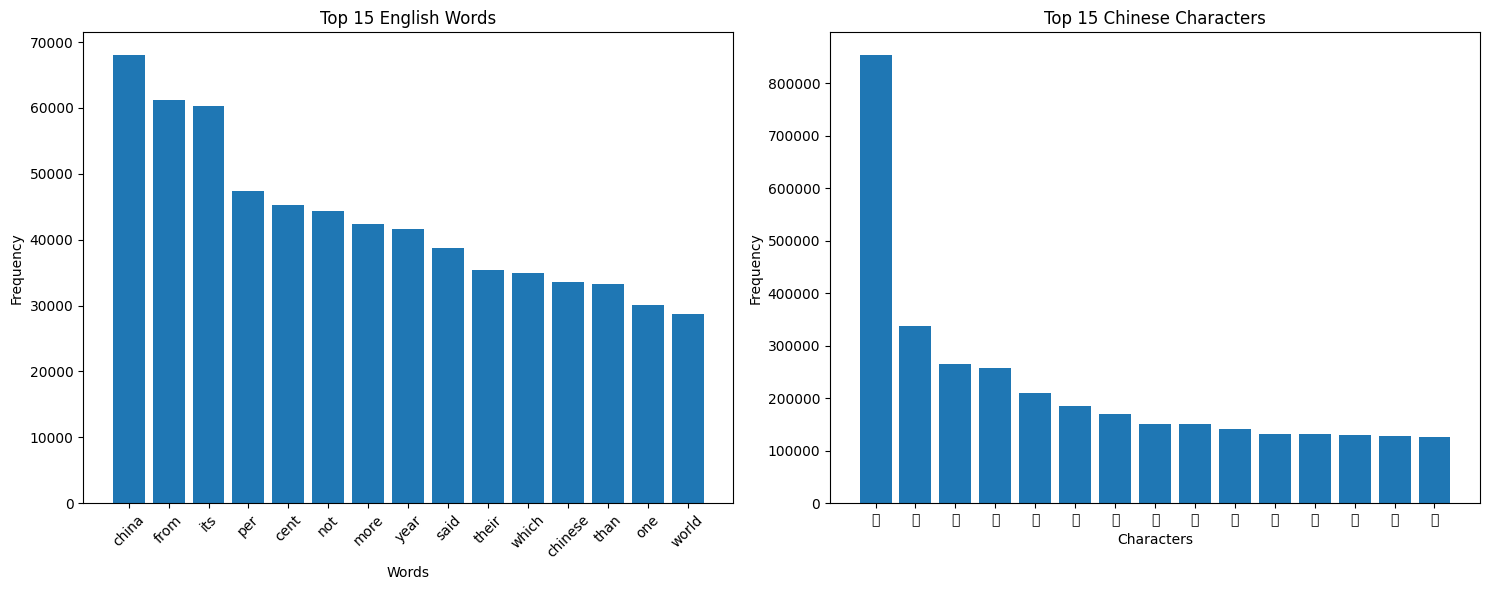


Average English article length: 135.2 words
Average Chinese article length: 353.4 characters


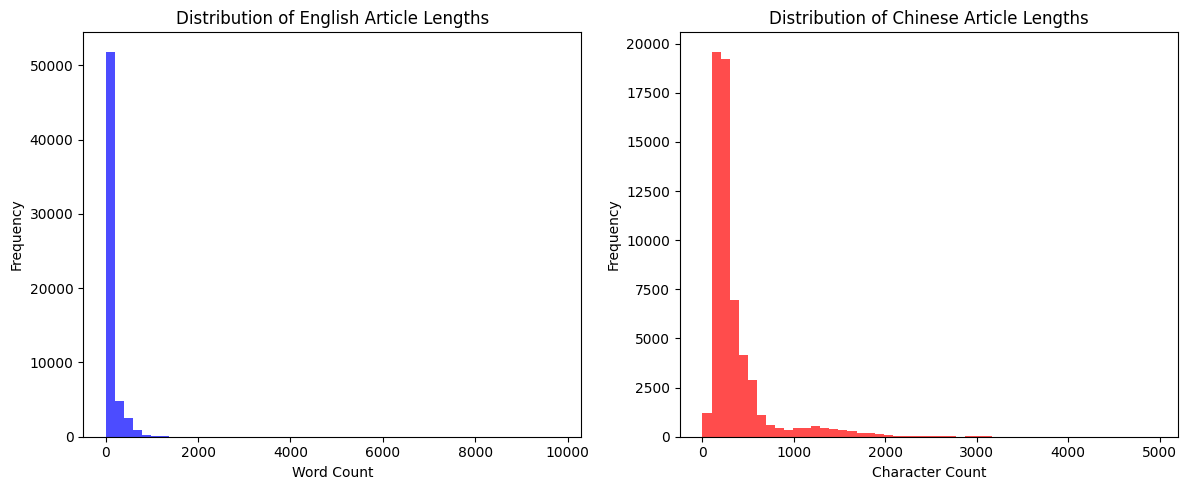

In [ ]:
# Visualize word frequencies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# English word frequencies
en_words, en_counts = zip(*english_freq.most_common(15))
ax1.bar(en_words, en_counts)
ax1.set_title('Top 15 English Words')
ax1.set_xlabel('Words')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='x', rotation=45)

# Chinese character frequencies
zh_chars, zh_counts = zip(*chinese_freq.most_common(15))
ax2.bar(zh_chars, zh_counts)
ax2.set_title('Top 15 Chinese Characters')
ax2.set_xlabel('Characters')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Let's also look at article lengths
df['english_word_count'] = df['english_body'].apply(lambda x: len(clean_english_text(x)))
df['chinese_char_count'] = df['chinese_body'].apply(lambda x: len(clean_chinese_text(x)))

print(f"\nAverage English article length: {df['english_word_count'].mean():.1f} words")
print(f"Average Chinese article length: {df['chinese_char_count'].mean():.1f} characters")

# Compare article lengths
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['english_word_count'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of English Article Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['chinese_char_count'], bins=50, alpha=0.7, color='red')
plt.title('Distribution of Chinese Article Lengths')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
def temporal_analysis(df):
    """Analyze how financial topics evolved over time WITH TRANSLATIONS"""
    print("🕐 TEMPORAL ANALYSIS WITH TRANSLATIONS")
    print("="*50)

    # Fix timezone warning by converting to timezone-naive datetime first
    df['time'] = pd.to_datetime(df['time']).dt.tz_localize(None)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.to_period('M')

    # Track keyword trends over time
    def track_keyword_over_time(keyword_en, keyword_zh, df):
        en_trend = df.groupby('year')['english_body'].apply(
            lambda x: x.str.contains(keyword_en, case=False, na=False).sum()
        )
        zh_trend = df.groupby('year')['chinese_body'].apply(
            lambda x: x.str.contains(keyword_zh, case=False, na=False).sum()
        )
        return en_trend, zh_trend

    # Define financial keywords to track
    keywords = {
        'crisis': '危机',
        'market': '市场',
        'investment': '投资',
        'trade': '贸易',
        'inflation': '通胀'
    }

    print("📈 Tracking these financial terms over time:")
    for en_term, zh_term in keywords.items():
        translated = translate_chinese_terms(zh_term)
        print(f"   • {en_term.title()} = {translated}")
    print()

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, (en_term, zh_term) in enumerate(keywords.items()):
        en_trend, zh_trend = track_keyword_over_time(en_term, zh_term, df)
        translated_zh = translate_chinese_terms(zh_term)

        axes[i].plot(en_trend.index, en_trend.values, 'b-', label=f'English ({en_term})', linewidth=2)
        axes[i].plot(zh_trend.index, zh_trend.values, 'r-', label=f'Chinese ({translated_zh})', linewidth=2)
        axes[i].set_title(f'Trend: {en_term.title()} vs {translated_zh}')
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel('Article Count')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    # Overall article count by year
    yearly_counts = df.groupby('year').size()
    axes[5].bar(yearly_counts.index, yearly_counts.values, alpha=0.7, color='green')
    axes[5].set_title('Total Articles by Year')
    axes[5].set_xlabel('Year')
    axes[5].set_ylabel('Article Count')
    axes[5].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✅ Temporal analysis complete!")
    return df  # Return df with new time columns


=== FINANCIAL EVENT DETECTION ===
Threshold for spike detection: 21.0 articles/day
Found 124 spike days


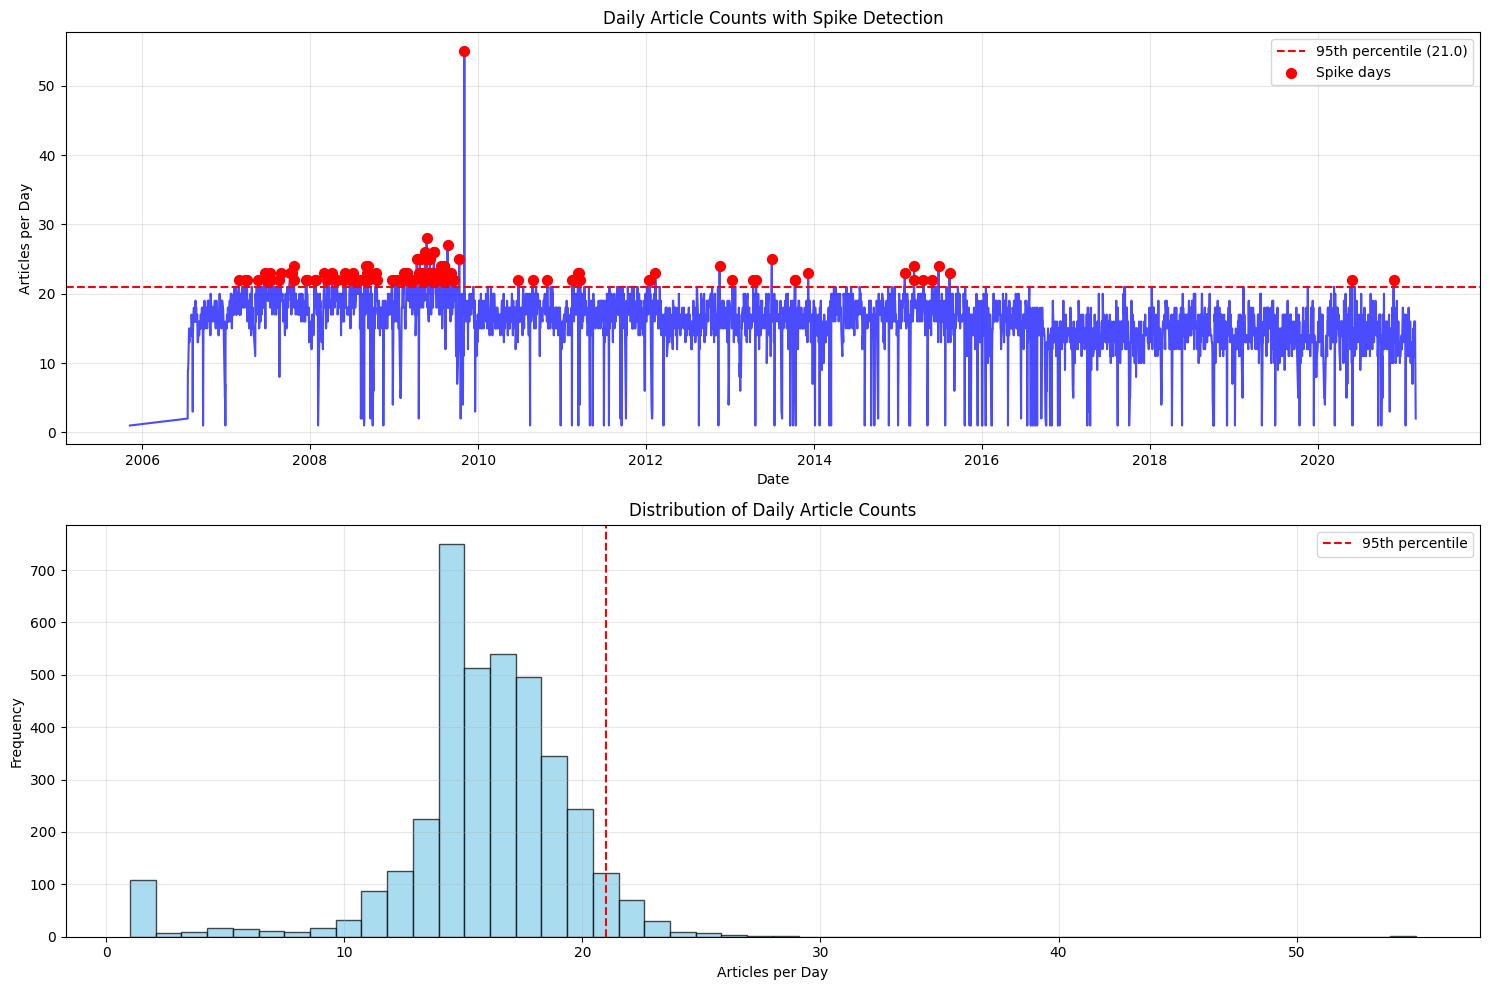


Top 5 spike days:
2009-11-02: 55 articles
  Sample titles:
    - Chinese writers seek redress on Google e-books
    - QUESTIONS REMAIN OVER CHINA'S CONSUMER POWER
    - SEOUL IN C$4.1BN HARVEST DEAL

2009-05-22: 28 articles
  Sample titles:
    - Brown considers Mandelson for Foreign Office
    - FSA BANS LONG-LUNCH TRADER FOR TWO YEARS
    - (lifestyle)_&_24932-32260

2009-08-21: 27 articles
  Sample titles:
    - MANUFACTURERS FEEL ‘HARDSHIP' OF CHINA CURRENCY
    - China acts to reduce health bills
    - SHORT VIEW

2009-05-15: 26 articles
  Sample titles:
    - Deep in a 1980s fashion renaissance
    - We was wondering if salesmen must speak proper
    - Legal services: The importance of friends

2009-06-22: 26 articles
  Sample titles:
    - Chinese groups cautious on advert spending
    - DOLLAR'S ROLE MAY SHRINK IN MULTI-CURRENCY GLOBAL REGIME
    - (lifestyle)_Youth_training_schemes_(921)-33104-33104-33104

Event detection complete!


In [ ]:
def financial_event_detection(df):
    """Identify major financial events by sudden spikes in articles"""
    print("\n=== FINANCIAL EVENT DETECTION ===")

    # Daily article counts
    daily_counts = df.groupby(df['time'].dt.date).size()

    # Find spike days (fixed syntax)
    threshold = daily_counts.quantile(0.95)
    spike_days = daily_counts[daily_counts > threshold]

    print(f"Threshold for spike detection: {threshold:.1f} articles/day")
    print(f"Found {len(spike_days)} spike days")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot daily counts over time
    ax1.plot(daily_counts.index, daily_counts.values, alpha=0.7, color='blue')
    ax1.axhline(y=threshold, color='red', linestyle='--', label=f'95th percentile ({threshold:.1f})')
    ax1.scatter(spike_days.index, spike_days.values, color='red', s=50, zorder=5, label='Spike days')
    ax1.set_title('Daily Article Counts with Spike Detection')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Articles per Day')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Distribution of daily counts
    ax2.hist(daily_counts.values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=threshold, color='red', linestyle='--', label=f'95th percentile')
    ax2.set_title('Distribution of Daily Article Counts')
    ax2.set_xlabel('Articles per Day')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Analyze top spike days
    print("\nTop 5 spike days:")
    top_spikes = spike_days.nlargest(5)
    for date, count in top_spikes.items():
        print(f"{date}: {count} articles")
        day_articles = df[df['time'].dt.date == date]
        print("  Sample titles:")
        for title in day_articles['english_title'].head(3):
            print(f"    - {title}")
        print()

    print("Event detection complete!")
    return spike_days

# FINANCIAL EVENT DETECTION:
spike_days = financial_event_detection(df)

In [ ]:
def cross_cultural_analysis(df):
    """Compare which topics get more coverage in each language WITH TRANSLATIONS"""
    print("\n🌍 CROSS-CULTURAL TOPIC ANALYSIS WITH TRANSLATIONS")
    print("="*55)

    financial_terms = {
        'stock': '股票',
        'market': '市场',
        'investment': '投资',
        'economy': '经济',
        'trade': '贸易',
        'inflation': '通胀',
        'bank': '银行',
        'debt': '债务',
        'growth': '增长',
        'profit': '利润'
    }

    print("🔍 Analyzing coverage differences for:")
    for en_term, zh_term in financial_terms.items():
        translated = translate_chinese_terms(zh_term)
        print(f"   {en_term.title():<12} = {translated}")
    print()

    coverage_data = []
    for en_term, zh_term in financial_terms.items():
        en_count = df['english_body'].str.contains(en_term, case=False, na=False).sum()
        zh_count = df['chinese_body'].str.contains(zh_term, case=False, na=False).sum()

        coverage_data.append({
            'term': en_term,
            'chinese_term': zh_term,
            'translated_term': translate_chinese_terms(zh_term),
            'english': en_count,
            'chinese': zh_count,
            'ratio': en_count / max(zh_count, 1)  # Avoid division by zero
        })

    coverage_df = pd.DataFrame(coverage_data)

    # Print results with translations
    print("📊 COVERAGE ANALYSIS RESULTS:")
    print("-" * 70)
    print(f"{'English Term':<12} | {'Chinese (Translation)':<25} | {'EN':<5} | {'ZH':<5} | {'Ratio':<6}")
    print("-" * 70)

    for _, row in coverage_df.iterrows():
        print(f"{row['term'].title():<12} | {row['translated_term']:<25} | "
              f"{row['english']:<5} | {row['chinese']:<5} | {row['ratio']:<6.2f}")

    # Visualization (keep your existing visualization code)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Bar chart comparison
    x = np.arange(len(coverage_df))
    width = 0.35

    ax1.bar(x - width/2, coverage_df['english'], width, label='English', alpha=0.8)
    ax1.bar(x + width/2, coverage_df['chinese'], width, label='Chinese', alpha=0.8)
    ax1.set_title('Term Frequency Comparison')
    ax1.set_xlabel('Financial Terms')
    ax1.set_ylabel('Frequency')
    ax1.set_xticks(x)
    ax1.set_xticklabels(coverage_df['term'], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Ratio analysis
    ax2.bar(coverage_df['term'], coverage_df['ratio'], color='orange', alpha=0.7)
    ax2.axhline(y=1, color='red', linestyle='--', label='Equal coverage')
    ax2.set_title('English/Chinese Coverage Ratio')
    ax2.set_xlabel('Financial Terms')
    ax2.set_ylabel('Ratio (>1 = more English coverage)')
    ax2.set_xticklabels(coverage_df['term'], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Heatmap
    heatmap_data = coverage_df[['english', 'chinese']].T
    heatmap_data.columns = coverage_df['term']
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', ax=ax3)
    ax3.set_title('Coverage Heatmap')

    plt.tight_layout()
    plt.show()

    print("✅ Cross-cultural analysis complete!")
    print(f"Coverage data shape: {coverage_df.shape}")
    return coverage_df


=== NAMED ENTITY ANALYSIS ===
Extracting organizations...
Extracting countries...


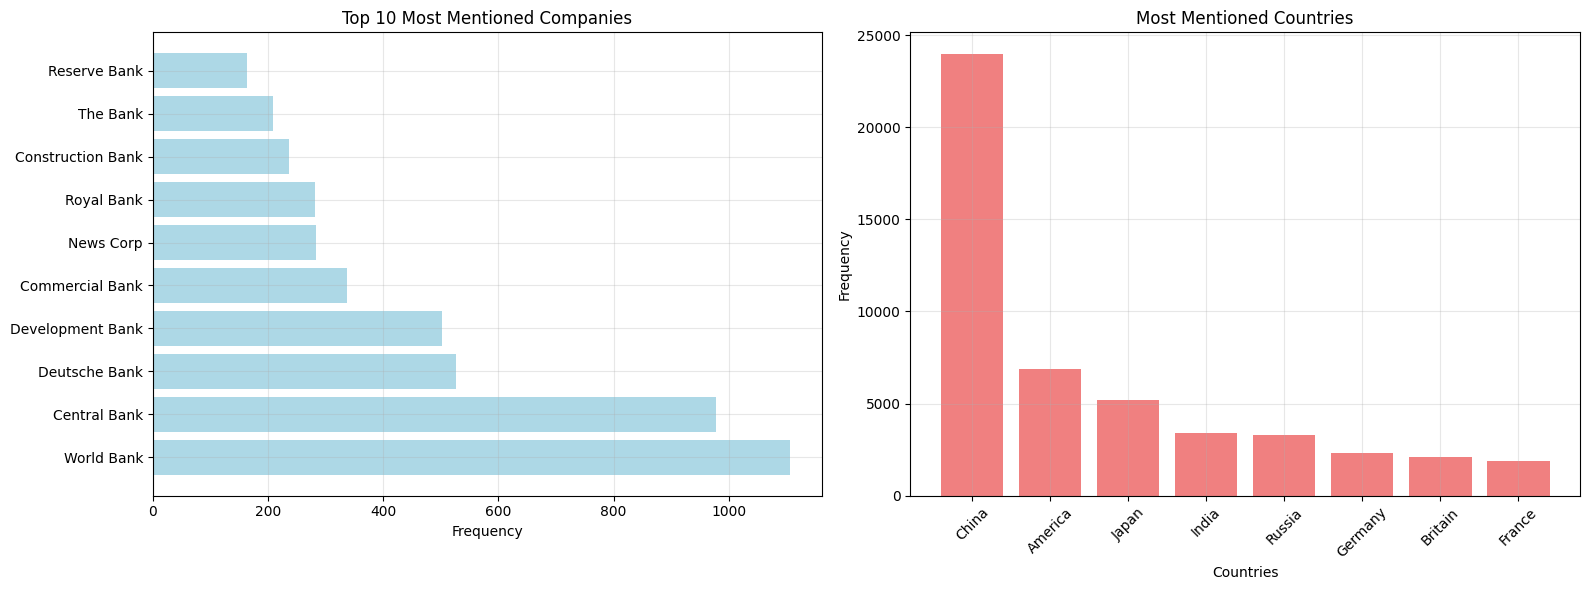

Named entity analysis complete!
Found 1743 unique companies, 9 unique countries


In [ ]:
def named_entity_analysis(df):
    """Compare how companies/people are mentioned differently"""
    print("\n=== NAMED ENTITY ANALYSIS ===")

    def extract_organizations(text):
        if pd.isna(text):
            return []
        # Pattern for company names
        companies = re.findall(r'\b[A-Z][a-zA-Z]+ (?:Corp|Inc|Ltd|Company|Bank|Group|Holdings|Financial|Capital)\b', str(text))
        return companies

    def extract_countries(text):
        if pd.isna(text):
            return []
        countries = ['China', 'United States', 'America', 'Britain', 'Japan', 'Germany', 'France', 'India', 'Russia']
        found = []
        for country in countries:
            if country.lower() in str(text).lower():
                found.append(country)
        return found

    # Extract entities
    print("Extracting organizations...")
    en_companies = []
    for text in df['english_body']:
        en_companies.extend(extract_organizations(text))

    print("Extracting countries...")
    en_countries = []
    for text in df['english_body']:
        en_countries.extend(extract_countries(text))

    company_freq = Counter(en_companies)
    country_freq = Counter(en_countries)

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Top companies
    if company_freq:
        top_companies = company_freq.most_common(10)
        companies, counts = zip(*top_companies)
        ax1.barh(companies, counts, color='lightblue')
        ax1.set_title('Top 10 Most Mentioned Companies')
        ax1.set_xlabel('Frequency')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No companies found', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Companies (None Found)')

    # Top countries
    if country_freq:
        top_countries = country_freq.most_common(8)
        countries, counts = zip(*top_countries)
        ax2.bar(countries, counts, color='lightcoral')
        ax2.set_title('Most Mentioned Countries')
        ax2.set_xlabel('Countries')
        ax2.set_ylabel('Frequency')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No countries found', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Countries (None Found)')

    plt.tight_layout()
    plt.show()

    print("Named entity analysis complete!")
    print(f"Found {len(company_freq)} unique companies, {len(country_freq)} unique countries")
    return company_freq, country_freq

# NAMED ENTITY ANALYSIS:
company_freq, country_freq = named_entity_analysis(df)


=== ARTICLE STRUCTURE ANALYSIS ===


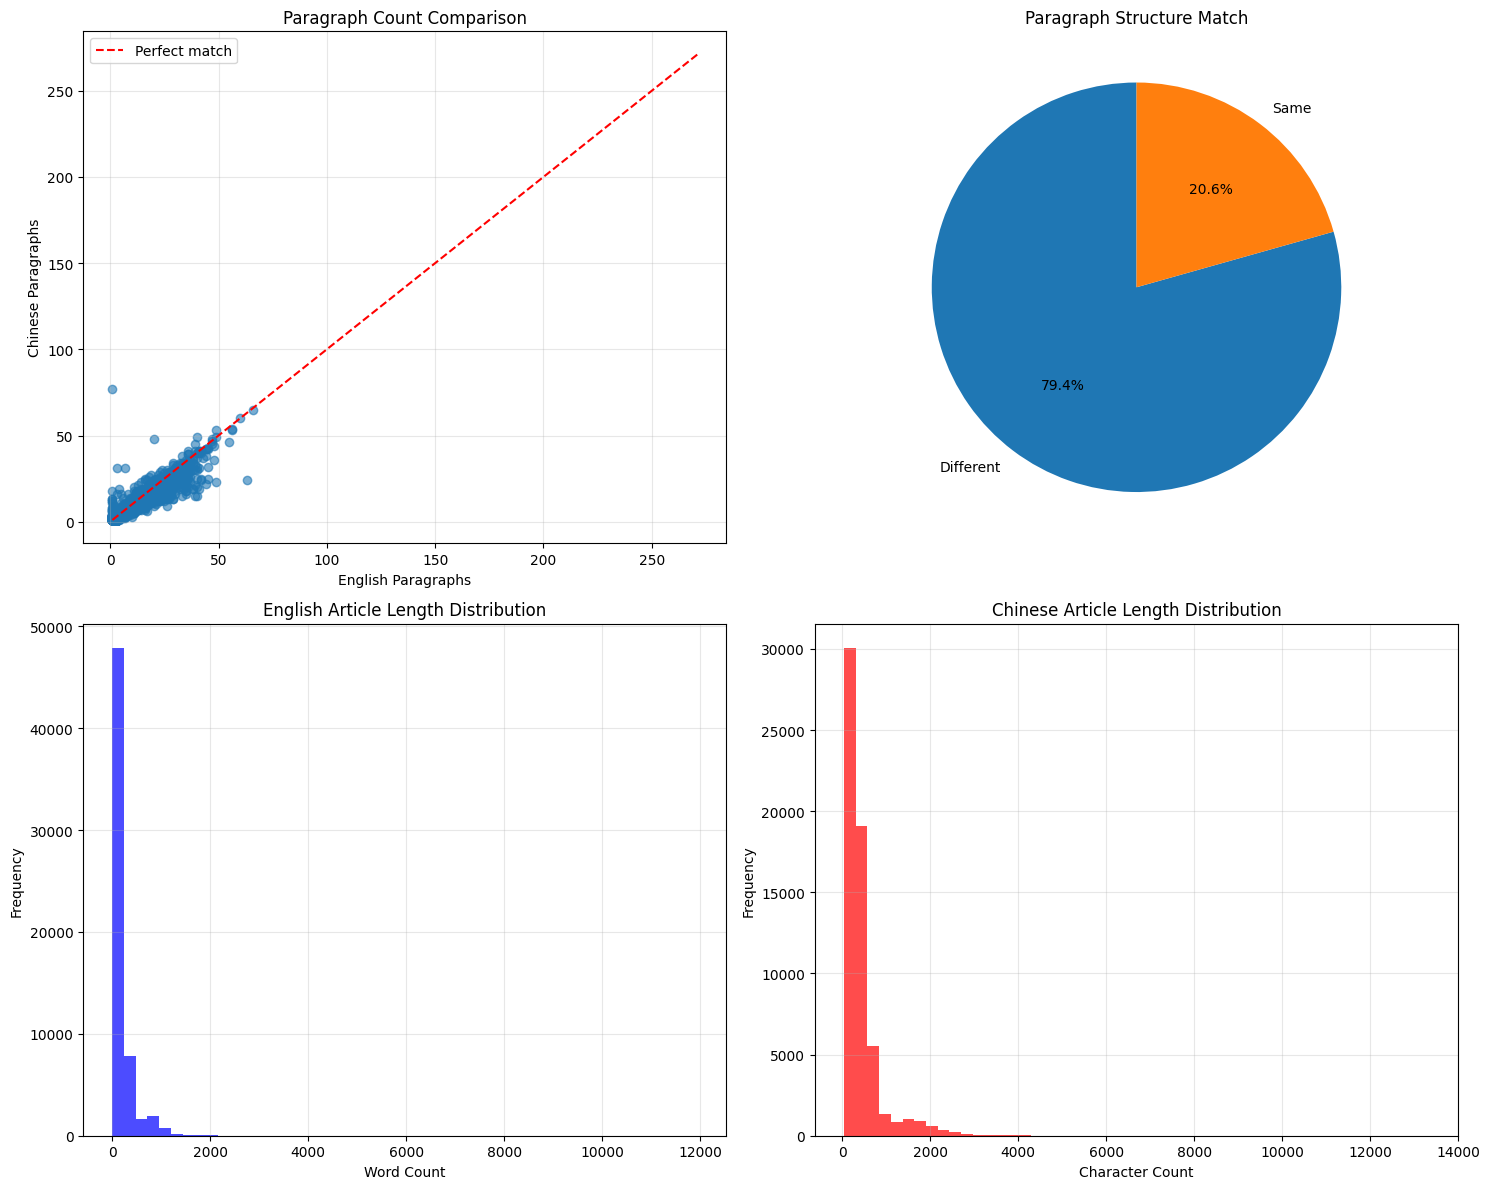

Articles with matching paragraph structure: 47947 (79.4%)
Average English article length: 210.2 words
Average Chinese article length: 461.3 characters
Average length ratio (EN words/CH chars): 0.465
Article structure analysis complete!


In [ ]:
def article_structure_analysis(df):
    """Analyze if articles have similar structure"""
    print("\n=== ARTICLE STRUCTURE ANALYSIS ===")

    # Compare paragraph counts (using @ as separator)
    df['en_paragraphs'] = df['english_body'].str.count('@') + 1
    df['zh_paragraphs'] = df['chinese_body'].str.count('@') + 1

    # Word/character counts
    df['english_word_count'] = df['english_body'].str.split().str.len()
    df['chinese_char_count'] = df['chinese_body'].str.len()

    # Check structural similarity
    df['paragraph_match'] = df['en_paragraphs'] == df['zh_paragraphs']
    df['length_ratio'] = df['english_word_count'] / df['chinese_char_count'].replace(0, 1)

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Paragraph count comparison
    ax1.scatter(df['en_paragraphs'], df['zh_paragraphs'], alpha=0.6)
    ax1.plot([1, df['en_paragraphs'].max()], [1, df['en_paragraphs'].max()], 'r--', label='Perfect match')
    ax1.set_xlabel('English Paragraphs')
    ax1.set_ylabel('Chinese Paragraphs')
    ax1.set_title('Paragraph Count Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Paragraph match distribution
    match_counts = df['paragraph_match'].value_counts()
    ax2.pie(match_counts.values, labels=['Different', 'Same'], autopct='%1.1f%%', startangle=90)
    ax2.set_title('Paragraph Structure Match')

    # Length distributions
    ax3.hist(df['english_word_count'], bins=50, alpha=0.7, label='English (words)', color='blue')
    ax3.set_xlabel('Word Count')
    ax3.set_ylabel('Frequency')
    ax3.set_title('English Article Length Distribution')
    ax3.grid(True, alpha=0.3)

    ax4.hist(df['chinese_char_count'], bins=50, alpha=0.7, label='Chinese (chars)', color='red')
    ax4.set_xlabel('Character Count')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Chinese Article Length Distribution')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Articles with matching paragraph structure: {df['paragraph_match'].sum()} ({df['paragraph_match'].mean()*100:.1f}%)")
    print(f"Average English article length: {df['english_word_count'].mean():.1f} words")
    print(f"Average Chinese article length: {df['chinese_char_count'].mean():.1f} characters")
    print(f"Average length ratio (EN words/CH chars): {df['length_ratio'].mean():.3f}")

    print("Article structure analysis complete!")
    return df

# ARTICLE STRUCTURE ANALYSIS:
df = article_structure_analysis(df)


=== TIME-BASED EVENT ANALYSIS ===


/tmp/ipython-input-18-1740289170.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['time'].dt.to_period('W')
/tmp/ipython-input-18-1740289170.py:32: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts = df.groupby(df['time'].dt.to_period('M')).size()


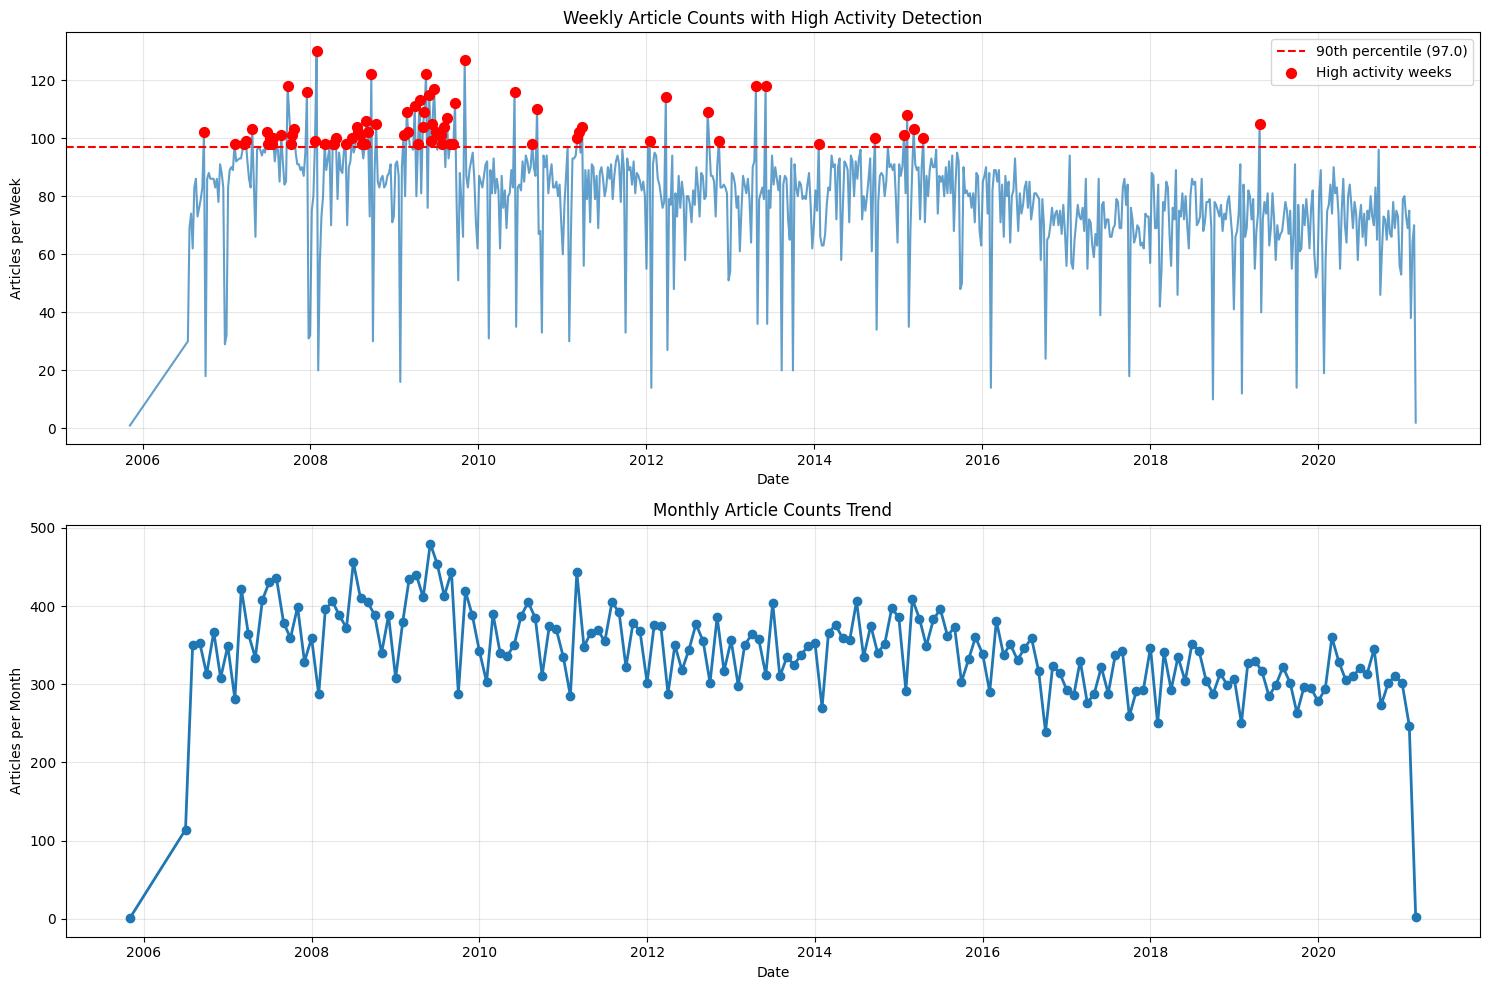

Found 75 high activity weeks (>90th percentile)

Top 5 high activity weeks:

Week 2008-01-28/2008-02-03: 130 articles
Sample titles:
  - Korea opportunities
  - Gamble Money
  - For sovereign funds, silence may not always be golden

Week 2009-11-02/2009-11-08: 127 articles
Sample titles:
  - Chinese writers seek redress on Google e-books
  - QUESTIONS REMAIN OVER CHINA'S CONSUMER POWER
  - SEOUL IN C$4.1BN HARVEST DEAL

Week 2008-09-22/2008-09-28: 122 articles
Sample titles:
  - (Lunch with the FT) China's Oprah 1736
  - TESTING TIME STARTS EARLY FOR AN MBA
  - POST-GRADUATE SCHOOLS ON WINNING STREAK

Week 2009-05-18/2009-05-24: 122 articles
Sample titles:
  - Tough task of turning recruits into innovators
  - POLITICIANS DEMONISE BUSINESS AT THEIR PERIL
  - What smart truckers tell us about the road to success

Week 2007-09-24/2007-09-30: 118 articles
Sample titles:
  - ‘The Armani of body armour'
  - Approaching a pinnacle of achievement
  - GREED AND BETRAYAL SEALED FATE
Time-based 

In [ ]:
def time_based_event_analysis(df):
    """Identify major financial events by clustering articles by date and content similarity"""
    print("\n=== TIME-BASED EVENT ANALYSIS ===")

    # Group articles by week
    df['week'] = df['time'].dt.to_period('W')
    weekly_counts = df.groupby('week').size()

    # Find weeks with unusually high activity
    high_activity_weeks = weekly_counts[weekly_counts > weekly_counts.quantile(0.9)]

    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Weekly article counts
    ax1.plot(weekly_counts.index.to_timestamp(), weekly_counts.values, alpha=0.7)
    threshold = weekly_counts.quantile(0.9)
    ax1.axhline(y=threshold, color='red', linestyle='--', label=f'90th percentile ({threshold:.1f})')

    # Highlight high activity weeks
    high_weeks_x = high_activity_weeks.index.to_timestamp()
    high_weeks_y = high_activity_weeks.values
    ax1.scatter(high_weeks_x, high_weeks_y, color='red', s=50, zorder=5, label='High activity weeks')

    ax1.set_title('Weekly Article Counts with High Activity Detection')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Articles per Week')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Monthly aggregation for trend analysis
    monthly_counts = df.groupby(df['time'].dt.to_period('M')).size()
    ax2.plot(monthly_counts.index.to_timestamp(), monthly_counts.values, marker='o', linewidth=2)
    ax2.set_title('Monthly Article Counts Trend')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Articles per Month')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Analyze high activity weeks
    print(f"Found {len(high_activity_weeks)} high activity weeks (>90th percentile)")
    print("\nTop 5 high activity weeks:")
    top_weeks = high_activity_weeks.nlargest(5)

    for week, count in top_weeks.items():
        print(f"\nWeek {week}: {count} articles")
        week_articles = df[df['week'] == week]
        print("Sample titles:")
        for title in week_articles['english_title'].head(3):
            print(f"  - {title}")

    print("Time-based event analysis complete!")
    return high_activity_weeks

# TIME-BASED EVENT ANALYSIS:
high_activity_weeks = time_based_event_analysis(df)


=== TOPIC MODELING PREPARATION ===
Cleaning text...
Creating TF-IDF matrix...
Running LDA topic modeling...

Top 8 topics found:
Topic 1: company, china, apple, chinese, google, companies, internet, technology, mobile, said
Topic 2: kong, hong, china, bank, company, chinese, investors, investment, shares, group
Topic 3: says, people, business, like, work, new, school, time, years, just
Topic 4: oil, china, energy, world, countries, india, gas, chinese, prices, global
Topic 5: cent, year, growth, china, prices, quarter, economy, market, index, sales
Topic 6: trump, mr, president, trade, obama, donald, eu, russia, said, election
Topic 7: bank, banks, financial, central, debt, crisis, currency, markets, monetary, rates
Topic 8: china, chinese, said, korea, north, beijing, mr, party, south, government


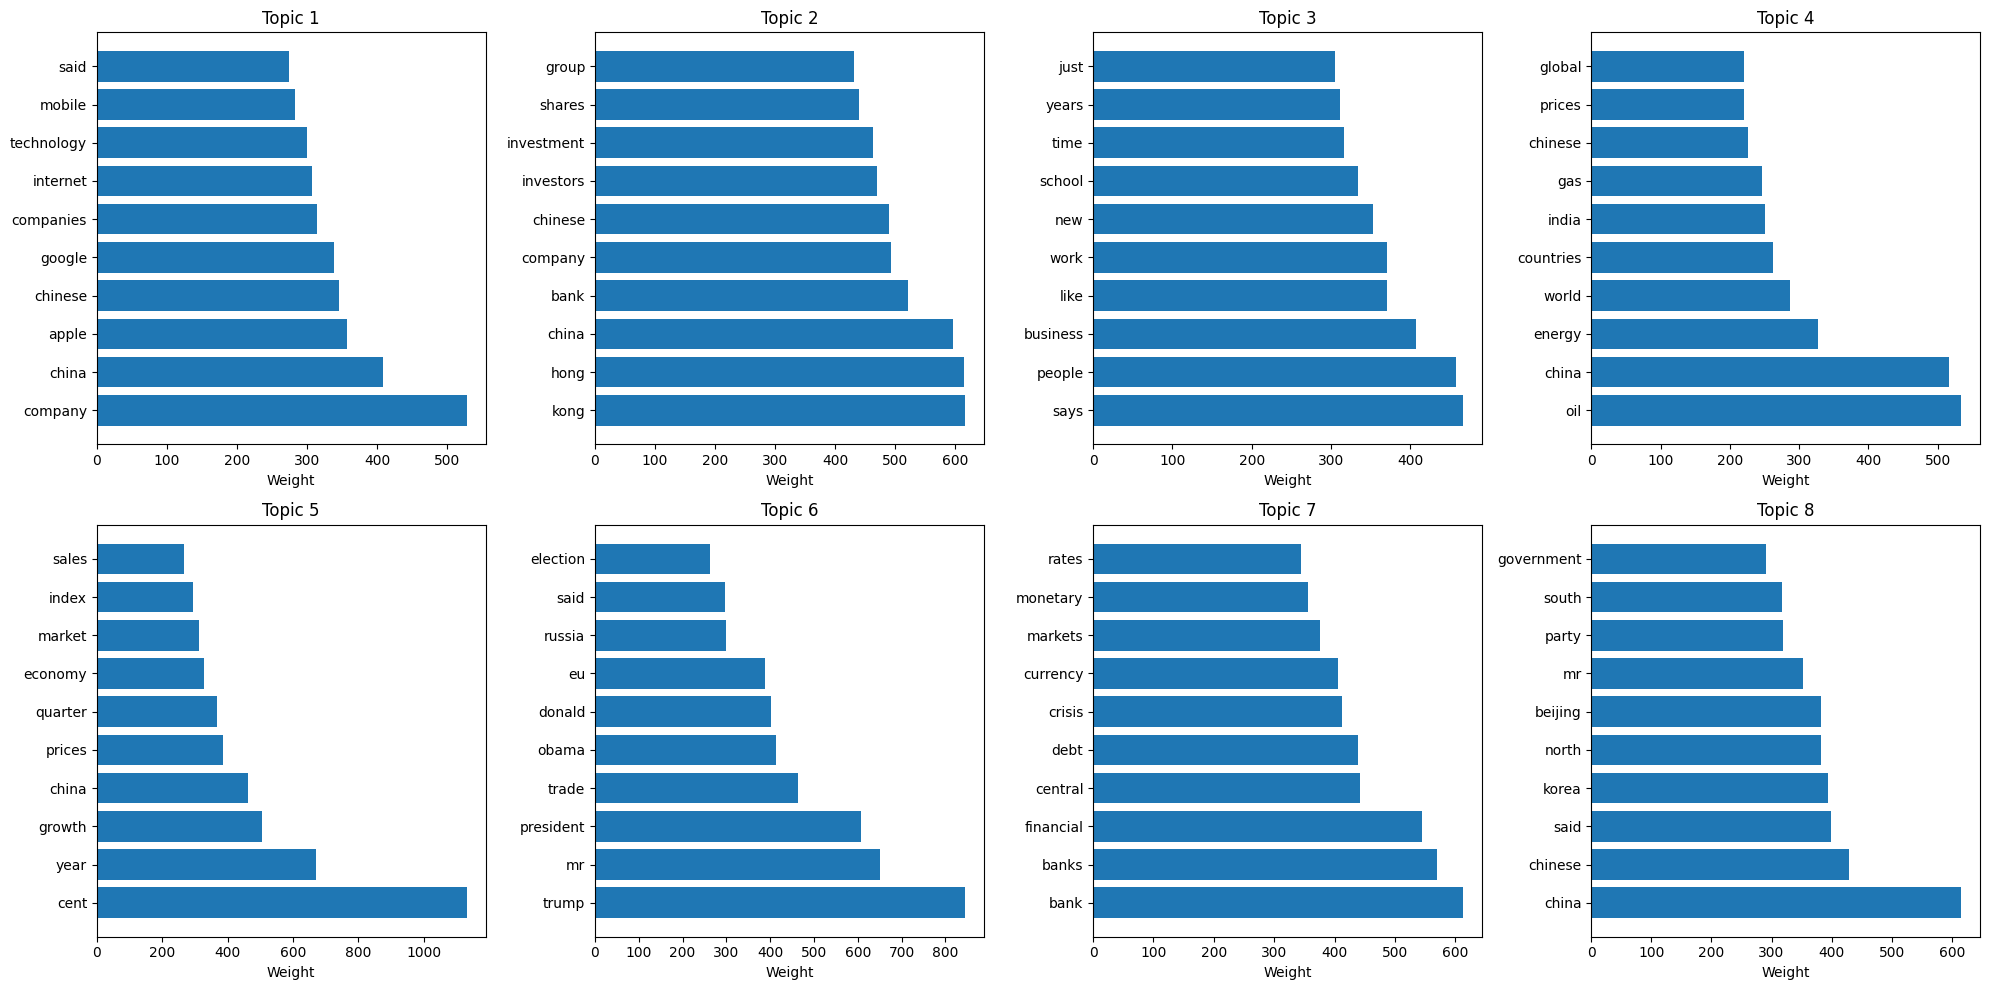

Topic modeling complete!


In [ ]:
def prepare_for_topic_modeling(df):
    """Prepare data for topic modeling"""
    print("\n=== TOPIC MODELING PREPARATION ===")

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.decomposition import LatentDirichletAllocation

    # Clean and prepare text
    def clean_text_for_modeling(text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text

    # Prepare English corpus
    print("Cleaning text...")
    english_corpus = [clean_text_for_modeling(text) for text in df['english_body']]

    # Create TF-IDF matrix
    print("Creating TF-IDF matrix...")
    vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        min_df=5,  # Ignore terms that appear in less than 5 documents
        max_df=0.8  # Ignore terms that appear in more than 80% of documents
    )

    tfidf_matrix = vectorizer.fit_transform(english_corpus)
    feature_names = vectorizer.get_feature_names_out()

    # Simple topic modeling with LDA
    print("Running LDA topic modeling...")
    n_topics = 8
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=100)
    lda.fit(tfidf_matrix)

    # Display topics
    def display_topics(model, feature_names, no_top_words=10):
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            top_words_idx = topic.argsort()[-no_top_words:][::-1]
            top_words = [feature_names[i] for i in top_words_idx]
            topics.append(top_words)
            print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
        return topics

    print(f"\nTop {n_topics} topics found:")
    topics = display_topics(lda, feature_names)

    # Visualize topic word importance
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[-10:][::-1]
        top_words = [feature_names[j] for j in top_words_idx]
        top_weights = topic[top_words_idx]

        axes[i].barh(top_words, top_weights)
        axes[i].set_title(f'Topic {i+1}')
        axes[i].set_xlabel('Weight')

    plt.tight_layout()
    plt.show()

    print("Topic modeling complete!")
    return tfidf_matrix, vectorizer, lda, topics

# TOPIC MODELING:
tfidf_matrix, vectorizer, lda, topics = prepare_for_topic_modeling(df)